In [193]:
#load libraries 
import torch
from torchvision import transforms
import torch.nn as nn
from torchinfo import summary
from torch.utils.data import Dataset,DataLoader
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
import numpy as np
from pathlib import Path
from PIL import Image

In [194]:
# read the data
root_dir = "./datasets/breast_ultrasound/Dataset_BUSI_with_GT/"

In [195]:
path = Path(root_dir)

In [196]:
path.is_dir()

True

In [197]:
# Get all image paths (of all the orignal images Only)
image_paths = list(path.glob("*/*).png"))
print(len(image_paths))

780


In [198]:
image_paths[0].parent.name

'benign'

In [199]:
# Extract labels froom folder names 
labels = [path.parent.name for path in image_paths]


In [200]:
print("Number of images from Benign",labels.count("benign") )
print("Number of images from normal",labels.count("normal") )
print("Number of images from malignant",labels.count("malignant"))



Number of images from Benign 437
Number of images from normal 133
Number of images from malignant 210


In [201]:
# Label encoding the labels 
from sklearn.preprocessing import LabelEncoder

label_encode = LabelEncoder()

In [202]:
target_labels = label_encode.fit_transform(labels)

In [203]:
image_paths = np.array(image_paths)

In [204]:
X_train, X_test, y_train, y_test = train_test_split(
    image_paths,
    target_labels,
    test_size=0.2,        # 20% test
    random_state=42,
    shuffle=True,
    stratify=target_labels  # VERY important for classification
)

In [205]:
# build custom dataset and dataloader 
class CustomDataset(Dataset): 
    def __init__(self,image_paths,labels): 
        self.images = image_paths
        self.labels = labels


    def __len__(self): 
        return len(self.images)


    def __getitem__(self,index):
        images = Image.open(self.images[index]).convert("RGB")
        
        # Convert to Tensor 
        images = transforms.ToTensor()(images)
        # Resize the image size
        resize_transform = transforms.Resize((224, 224))
        # Apply the transform
        resized_img = resize_transform(images)
        # labels 
        labels = torch.tensor(self.labels[index])
        return resized_img,labels

In [206]:
X_train_dataset = CustomDataset(X_train,y_train)
X_test_dataset = CustomDataset(X_test,y_test)

In [207]:
X_train_dataloader = DataLoader(X_train_dataset,batch_size=32,shuffle=True,drop_last=True)
X_test_dataloader = DataLoader(X_test_dataset,batch_size=32,shuffle=False,drop_last=True)

In [209]:
len(X_train_dataset)

624

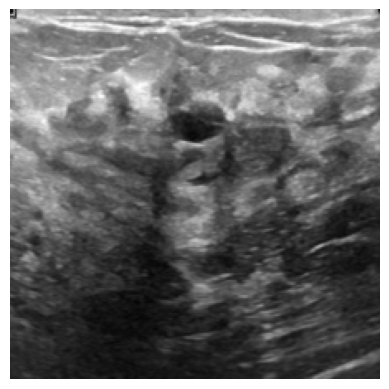

In [210]:

# Convert the tensor to channel-last format
image_np = X_train_dataset[1][0].permute(1, 2, 0).numpy()

# Display the image
plt.imshow(image_np)
plt.axis('off')  # Turn off axis labels
plt.show()

In [238]:
class MyModelEnhanced(nn.Module):
    def __init__(self, in_channels=3, num_classes=3):
        super().__init__()

        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(in_channels, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.MaxPool2d(2),

            # Block 2
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2),

            # Block 3
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.MaxPool2d(2),

            # Block 4 (optional but powerful)
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.MaxPool2d(2),

            # Fix feature size
            nn.AdaptiveAvgPool2d((7, 7))
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 7 * 7, 256),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [239]:
# Configuration of My model 
learning_rate = 0.02
epochs = 50
loss_function = nn.CrossEntropyLoss()

In [240]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [241]:
device

device(type='cuda')

In [242]:
model = MyModelEnhanced(3)
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
torch.manual_seed(1123)
# training loop 
for epoch in range(epochs): 
    total_epoch_loss = 0
    for batch_images,batch_labels in X_train_dataloader: 
        batch_images = batch_images.to(device)
        batch_labels = batch_labels.to(device)
        # pass forward 
        y_pred = model(batch_images)
        # loss calculate
        loss = loss_function(y_pred,batch_labels)
        
        # Clear the gradient 
        optimizer.zero_grad()
        # Backward propgationabs
        loss.backward()

        # Update weights 
        optimizer.step()
        total_epoch_loss += loss.item()

    print(f"Epoch {epoch + 1} : ",total_epoch_loss/len(X_train_dataloader))
        

Epoch 1 :  0.992573408704055
Epoch 2 :  0.9188727799214815
Epoch 3 :  0.8800974331404033
Epoch 4 :  0.8220889474216261
Epoch 5 :  0.7437029982867994
Epoch 6 :  0.7509431682134929
Epoch 7 :  0.6960212792220869
Epoch 8 :  0.6292360848502109
Epoch 9 :  0.5711912999027654
Epoch 10 :  0.5496952753317984
Epoch 11 :  0.5438569313601443
Epoch 12 :  0.4725181303526226
Epoch 13 :  0.44620007433389364
Epoch 14 :  0.3906405928887819
Epoch 15 :  0.40041149682120275
Epoch 16 :  0.3030051259618056
Epoch 17 :  0.602833913345086
Epoch 18 :  0.33843599887270676
Epoch 19 :  0.32007589151984767
Epoch 20 :  0.22321279739078723
Epoch 21 :  0.28658699518755865
Epoch 22 :  0.19169479471288228
Epoch 23 :  0.1790254782689245
Epoch 24 :  0.1861917526510201
Epoch 25 :  0.15609199043951535
Epoch 26 :  0.11281369842196766
Epoch 27 :  0.14884530664666704
Epoch 28 :  0.0861649703430502
Epoch 29 :  0.07966734125818077
Epoch 30 :  0.1551045861683394
Epoch 31 :  0.08118618534583795
Epoch 32 :  0.05468238806842189
Epoch 

In [247]:
# Evaluation of the model : Now the model will stop learning and modification into the exisiting learn parameters
model.eval()

MyModelEnhanced(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), paddi

In [248]:

all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in X_test_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()


In [249]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)


Confusion Matrix:
 [[63  5  6]
 [ 2 30  1]
 [ 1  3 17]]


In [250]:
from sklearn.metrics import classification_report

print(classification_report(
    all_labels,
    all_preds,
    target_names=["Benign", "Malignant", "Normal"]  # adjust order
))


              precision    recall  f1-score   support

      Benign       0.95      0.85      0.90        74
   Malignant       0.79      0.91      0.85        33
      Normal       0.71      0.81      0.76        21

    accuracy                           0.86       128
   macro avg       0.82      0.86      0.83       128
weighted avg       0.87      0.86      0.86       128



In [251]:
torch.save(model.state_dict(), "./models/model_rgb_epoch_50_dropout_0_2.pth")


In [ ]:
#model = MyModel(...)          # recreate architecture
#model.load_state_dict(torch.load("model.pth"))
#model.eval()
